In [1]:
using NCDatasets

In [2]:
using CairoMakie

In [3]:
using OceanBioME, Oceananigans, Printf
using OceanBioME: Boundaries, GasExchange
using OceanBioME.Boundaries.Sediments: sinking_flux
using OceanBioME.SLatissimaModel: SLatissima
using Oceananigans.Fields: FunctionField, ConstantField
using Oceananigans.Units
using JLD2

import Oceananigans.Biogeochemistry: update_tendencies!
import Oceananigans.Biogeochemistry: required_biogeochemical_tracers,
                                     required_biogeochemical_auxiliary_fields,
                                     biogeochemical_drift_velocity

In [4]:
using Oceananigans.Forcings

In [5]:
using Oceananigans: architecture

In [6]:
using DelimitedFiles, FileIO

In [7]:
using Oceananigans.Operators: ℑxyᶠᶜᵃ, ℑxyᶜᶠᵃ
using Oceananigans.Operators: Δzᵃᵃᶜ

In [8]:
using Statistics
using SeawaterPolynomials.TEOS10: TEOS10EquationOfState
using CUDA: @allowscalar

In [9]:
using Interpolations

In [10]:
using CSV, DataFrames

# TODO

### General
- make on GPU
- read INI, BRY and forcings from netcdf
- write output to netcdf
- add sea domain
- TimeStepWizard (problems with stability)
- Checkpointer
### Rivers
- add NUT and DOM supply from the river (+ contaminant)
- add level forcing from the river
- adjust the discharge
### Open boundary
- read from netcdf
- need T, S, velocities from Black Sea
### Atmosphere
- heat flux
- precipitation
### BGC
- add contaminant
### INI
- adjust initial conditions to literature

In [11]:
arch = CPU()

CPU()

In [12]:
save_interval = 30minutes

1800.0

# Grid

## define z-levels (faces and center points)

In [14]:
# z_levels = stretched_vertical_faces(depth = 300, 
#                              surface_layer_Δz = 2.5, 
#                              stretching = PowerLawStretching(1.090), 
#                              surface_layer_height = 30)
# z-levels from Andre
z_levels = -reverse([0.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
z_middle = -reverse([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5])

20-element Vector{Float64}:
 -19.5
 -18.5
 -17.5
 -16.5
 -15.5
 -14.5
 -13.5
 -12.5
 -11.5
 -10.5
  -9.5
  -8.5
  -7.5
  -6.5
  -5.5
  -4.5
  -3.5
  -2.5
  -1.5
  -0.5

In [15]:
writedlm( "z-grid_Tyr.csv",  z_levels, ',')

## underlying grid

In [16]:
Nx = 119
Ny = 42
Nz = length(z_levels)-1

20

In [17]:
dx = 200  # m
dy = 50  # m

50

In [18]:
underlying_grid = RectilinearGrid(topology=(Bounded, Bounded, Bounded), size=(Nx, Ny, Nz),
                                        x = (0, dx*Nx), y = (0, dy*Ny),
                                        z = z_levels, halo=(7,7,7))

119×42×20 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── Bounded  x ∈ [0.0, 23800.0] regularly spaced with Δx=200.0
├── Bounded  y ∈ [0.0, 2100.0]  regularly spaced with Δy=50.0
└── Bounded  z ∈ [-20.0, -0.0]  variably spaced with min(Δz)=1.0, max(Δz)=1.0

## load bathymetry

In [19]:
@load "Varna_topo.jld2" depth

1-element Vector{Symbol}:
 :depth

In [20]:
depth

119×42 Matrix{Float64}:
 0.0  0.0   0.0      0.0      0.0     …    0.0      0.0      0.0      0.0
 0.0  0.0   0.0      0.0      0.0          0.0      0.0      0.0      0.0
 0.0  0.0   0.0      0.0      0.0          0.0      0.0      0.0      0.0
 0.0  0.0   0.0      0.0      0.0          0.0      0.0      0.0      0.0
 0.0  0.0   0.0     -2.0501  -3.5769       0.0      0.0      0.0      0.0
 0.0  0.0  -1.8686  -3.4335  -4.9079  …    0.0      0.0      0.0      0.0
 0.0  0.0   0.0     -1.4476  -1.9712       0.0      0.0      0.0      0.0
 0.0  0.0   0.0      0.0      0.0          0.0      0.0      0.0      0.0
 0.0  0.0   0.0      0.0      0.0          0.0      0.0      0.0      0.0
 0.0  0.0   0.0     -1.5814  -2.4893       0.0      0.0      0.0      0.0
 0.0  0.0   0.0     -1.9075  -3.2924  …    0.0      0.0      0.0      0.0
 0.0  0.0   0.0      0.0     -1.0048       0.0      0.0      0.0      0.0
 0.0  0.0   0.0      0.0      0.0          0.0      0.0      0.0      0.0
 ⋮            

In [23]:
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(depth); active_cells_map = true)

119×42×20 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo:
├── immersed_boundary: GridFittedBottom(mean(z)=-3.77416, min(z)=-19.994, max(z)=0.0)
├── underlying_grid: 119×42×20 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── Bounded  x ∈ [0.0, 23800.0] regularly spaced with Δx=200.0
├── Bounded  y ∈ [0.0, 2100.0]  regularly spaced with Δy=50.0
└── Bounded  z ∈ [-20.0, -0.0]  variably spaced with min(Δz)=1.0, max(Δz)=1.0

# Biogeochemistry

In [221]:
const year = years = 365days
# ## Surface PAR
# Setting up idealised functions for PAR and diffusivity (details here can be ignored but these are typical of the North Atlantic)

@inline PAR⁰(x, y, t) = 60 * (1 - cos((t + 15days) * 2π / year)) * (1 / (1 + 0.2 * exp(-((mod(t, year) - 200days) / 50days)^2))) + 2

biogeochemistry = OXYDEP(; grid, 
                          surface_photosynthetically_active_radiation = PAR⁰,
                          particles = nothing)

OxygenDepletionModel{Float64} model, with (:PHY, :HET, :POM) sinking 
 Light attenuation: Two-band light attenuation model (Float64)
 Sediment: Nothing
 Particles: Nothing
 Modifiers: Nothing

In [206]:
?Oceananigans.Biogeochemistry.AbstractBiogeochemistry

```
AbstractBiogeochemistry
```

Abstract type for biogeochemical models. To define a biogeochemcial relaionship the following functions must have methods defined where `BiogeochemicalModel` is a subtype of `AbstractBioeochemistry`:

  * `(bgc::BiogeochemicalModel)(i, j, k, grid, ::Val{:tracer_name}, clock, fields)` which   returns the biogeochemical reaction for for each tracer.
  * `required_biogeochemical_tracers(::BiogeochemicalModel)` which returns a tuple of  required `tracer_names`.
  * `required_biogeochemical_auxiliary_fields(::BiogeochemicalModel)` which returns   a tuple of required auxiliary fields.
  * `biogeochemical_auxiliary_fields(bgc::BiogeochemicalModel)` which returns a `NamedTuple`  of the models auxiliary fields.
  * `biogeochemical_drift_velocity(bgc::BiogeochemicalModel, ::Val{:tracer_name})` which   returns a velocity fields (i.e. a `NamedTuple` of fields with keys `u`, `v` & `w`)  for each tracer.
  * `update_biogeochemical_state!(bgc::BiogeochemicalModel, model)` (optional) to update the   model state.


# Initial conditions

In [25]:
z_ini = -reverse([0.5, 1, 2, 3, 4, 6, 8, 9, 10, 12, 16, 20])

12-element Vector{Float64}:
 -20.0
 -16.0
 -12.0
 -10.0
  -9.0
  -8.0
  -6.0
  -4.0
  -3.0
  -2.0
  -1.0
  -0.5

In [26]:
tprof = reverse([20, 20, 20, 20, 18, 15, 14, 13, 12, 12, 12, 12])
itp = LinearInterpolation(z_ini, tprof)
tprof_target = itp(z_middle)

T₀ = Array{Float64}(undef, Nx, Ny, Nz)
for i = 1:Nx
    for j = 1:Ny
        T₀[i, j, :] = tprof_target
    end
end

In [27]:
sprof = reverse([14, 14.1, 14.2, 14.5, 14.8, 15, 15.1, 15.2, 15.3, 15.4, 15.5, 15.5])
itps = LinearInterpolation(z_ini, sprof)
sprof_target = itps(z_middle)

S₀ = Array{Float64}(undef, Nx, Ny, Nz)
for i = 1:Nx
    for j = 1:Ny
        S₀[i, j, :] = sprof_target
    end
end

# Physics

In [28]:
const surface_νz = 1e-2
const background_νz = 1e-4
const background_κz = 1e-5

@inline νz(x, y, z, t) = ifelse(z > -15, surface_νz, background_νz)

horizontal_viscosity = HorizontalScalarDiffusivity(ν=1e3)
vertical_viscosity   = VerticalScalarDiffusivity(VerticallyImplicitTimeDiscretization(),
                                                 ν=νz, κ=background_κz)
convective_adjustment = ConvectiveAdjustmentVerticalDiffusivity(convective_κz=0.1)
κ_skew = 900.0      # [m² s⁻¹] skew diffusivity
κ_symmetric = 900.0 # [m² s⁻¹] symmetric diffusivity

gent_mcwilliams_diffusivity = IsopycnalSkewSymmetricDiffusivity(; κ_skew, κ_symmetric,
                                                                slope_limiter = FluxTapering(1e-2))

    
closure = (
    vertical_viscosity,
    horizontal_viscosity,
    convective_adjustment,
    gent_mcwilliams_diffusivity,
)

(VerticalScalarDiffusivity{VerticallyImplicitTimeDiscretization}(ν=νz (generic function with 1 method), κ=1.0e-5), HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=1000.0, κ=0.0), ConvectiveAdjustmentVerticalDiffusivity{VerticallyImplicitTimeDiscretization}(background_κz=0.0 convective_κz=0.1 background_νz=0.0 convective_νz=0.0), IsopycnalSkewSymmetricDiffusivity: (κ_symmetric=900.0, κ_skew=900.0, (isopycnal_tensor=Oceananigans.TurbulenceClosures.SmallSlopeIsopycnalTensor{Float64}(0.0), slope_limiter=FluxTapering{Float64}(0.01)))

# Boundary conditions (u, v, T, S)

In [29]:
reference_density        = 1000.0
reference_heat_capacity  = 3991.0
reference_salinity       = 15

15

In [30]:
# Files contain 12 arrays of monthly-averaged data from 1992
# @info "Reading boundary conditions..."; start=time_ns()
# boundary_conditions_file = jldopen("surface_boundary_conditions_360_150_75S_75N.jld2")
# τˣ = - boundary_conditions_file["τˣ"] ./ reference_density
# τʸ = - boundary_conditions_file["τʸ"] ./ reference_density

In [31]:
# Convert boundary conditions arrays to GPU (CPU here)
# τˣ = on_architecture(arch, τˣ)
# τʸ = on_architecture(arch, τʸ)

## Wind stress
https://en.wikipedia.org/wiki/Wind_stress

In [32]:
Cd = 0.0025  # 0.0015
ρₐᵢᵣ = 1.225

1.225

In [33]:
# 8760-element

### Option 1. define monthly-averages (to test)

In [34]:
# Ntimes = 8760
Ntimes = 12

12

In [35]:
uwind = [10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
vwind = [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

12-element Vector{Int64}:
 8
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

### Option 2. or read from file (hourly)

In [36]:
# df = CSV.read("atm/wind2023_1h.csv", DataFrame)
# uwind = df.u
# vwind = df.v

### calculate the wind stress

In [37]:
τˣ = Array{Float64}(undef, Nx, Ny, Ntimes)
τʸ = Array{Float64}(undef, Nx, Ny, Ntimes)
for i = 1:Nx
    for j = 1:Ny
        τˣ[i, j, :] = -ρₐᵢᵣ*Cd.*(uwind.^2)./reference_density
        τʸ[i, j, :] = ρₐᵢᵣ*Cd.*(vwind.^2)./reference_density
    end
end

In [38]:
maximum(τʸ)

0.00019600000000000002

## Time-dependent fluxes

### for hourly wind input

In [338]:
# const Nyears = 1.0
# const Nhours = 1.0  # Only one hour, but we're working with fractions of it
# const seconds_in_hour = 3600  # Number of seconds in an hour

# # Inline functions for cyclic time indexing within an hour
# @inline current_time_index(time, tot_seconds) = mod(unsafe_trunc(Int32, time), tot_seconds) + 1
# @inline next_time_index(time, tot_seconds) = mod(unsafe_trunc(Int32, time) + 1, tot_seconds) + 1
# @inline cyclic_interpolate(u₁::Number, u₂, time) = u₁ + mod(time, 1) * (u₂ - u₁)

# # Assuming Δzᵃᵃᶜ and other grid and fields setup remains the same
# Δz_top = @allowscalar Δzᵃᵃᶜ(1, 1, grid.Nz, grid.underlying_grid)
# Δz_bottom = @allowscalar Δzᵃᵃᶜ(1, 1, 1, grid.underlying_grid)

# @inline function surface_wind_stress(i, j, grid, clock, fields, τ)
#     time = clock.time  # Assuming `time` is now given in seconds within the current hour
#     n₁ = current_time_index(time, seconds_in_hour)
#     n₂ = next_time_index(time, seconds_in_hour)

#     @inbounds begin
#         τ₁ = τ[i, j, n₁]
#         τ₂ = τ[i, j, n₂]
#     end

#     return cyclic_interpolate(τ₁, τ₂, time / seconds_in_hour)
# end


In [339]:
# const Nyears = 1.0
# const Nhours = 1.0  # Only one hour, but we're working with fractions of it
# const seconds_in_hour = 3600  # Number of seconds in an hour

# # Inline functions for cyclic time indexing within an hour
# @inline current_time_index(time, tot_seconds) = mod(unsafe_trunc(Int32, time), tot_seconds) + 1
# @inline next_time_index(time, tot_seconds) = mod(unsafe_trunc(Int32, time) + 1, tot_seconds) + 1
# @inline cyclic_interpolate(u₁::Number, u₂, time) = u₁ + mod(time, 1) * (u₂ - u₁)

# # Assuming Δzᵃᵃᶜ and other grid and fields setup remains the same
# Δz_top = @allowscalar Δzᵃᵃᶜ(1, 1, grid.Nz, grid.underlying_grid)
# Δz_bottom = @allowscalar Δzᵃᵃᶜ(1, 1, 1, grid.underlying_grid)

# @inline function surface_wind_stress(i, j, grid, clock, fields, τ)
#     time = clock.time  # Assuming `time` is now given in seconds within the current hour
#     n₁ = current_time_index(time, seconds_in_hour)
#     n₂ = next_time_index(time, seconds_in_hour)

#     @inbounds begin
#         τ₁ = τ[i, j, n₁]
#         τ₂ = τ[i, j, n₂]
#     end

#     return cyclic_interpolate(τ₁, τ₂, time / seconds_in_hour)
# end


### For monthly input

In [39]:
##### Boundary conditions / time-dependent fluxes 

const Nyears = 1.0
const Nmonths = 12
const thirty_days = 30days

@inline current_time_index(time, tot_months) = mod(unsafe_trunc(Int32, time / thirty_days), tot_months) + 1
@inline next_time_index(time, tot_months) = mod(unsafe_trunc(Int32, time / thirty_days) + 1, tot_months) + 1
@inline cyclic_interpolate(u₁::Number, u₂, time) = u₁ + mod(time / thirty_days, 1) * (u₂ - u₁)

Δz_top = @allowscalar Δzᵃᵃᶜ(1, 1, grid.Nz, grid.underlying_grid)
Δz_bottom = @allowscalar Δzᵃᵃᶜ(1, 1, 1, grid.underlying_grid)

@inline function surface_wind_stress(i, j, grid, clock, fields, τ)
    time = clock.time
    n₁ = current_time_index(time, Nmonths)
    n₂ = next_time_index(time, Nmonths)

    @inbounds begin  # inbounds for faster performance, doesn't check the boundaries of the array
        τ₁ = τ[i, j, n₁]
        τ₂ = τ[i, j, n₂]
    end

    return cyclic_interpolate(τ₁, τ₂, time)
end

surface_wind_stress (generic function with 1 method)

## Bottom drag

In [40]:
Δz_top = @allowscalar grid.Δzᵃᵃᶜ[Nz]

# Linear bottom drag:
μ = 0.003 # Non dimensional

@inline speedᶠᶜᶜ(i, j, k, grid, fields) = @inbounds sqrt(fields.u[i, j, k]^2 + ℑxyᶠᶜᵃ(i, j, k, grid, fields.v)^2)
@inline speedᶜᶠᶜ(i, j, k, grid, fields) = @inbounds sqrt(fields.v[i, j, k]^2 + ℑxyᶜᶠᵃ(i, j, k, grid, fields.u)^2)

@inline u_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, 1] * speedᶠᶜᶜ(i, j, 1, grid, fields)
@inline v_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, 1] * speedᶜᶠᶜ(i, j, 1, grid, fields)

@inline u_immersed_bottom_drag(i, j, k, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, k] * speedᶠᶜᶜ(i, j, k, grid, fields)
@inline v_immersed_bottom_drag(i, j, k, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, k] * speedᶜᶠᶜ(i, j, k, grid, fields)

drag_u = FluxBoundaryCondition(u_immersed_bottom_drag, discrete_form=true, parameters = μ)
drag_v = FluxBoundaryCondition(v_immersed_bottom_drag, discrete_form=true, parameters = μ)

no_slip_bc = ValueBoundaryCondition(0)

u_immersed_bc = ImmersedBoundaryCondition(bottom = drag_u,
                                          west = no_slip_bc,
                                          east = no_slip_bc,
                                          south = no_slip_bc,
                                          north = no_slip_bc)

v_immersed_bc = ImmersedBoundaryCondition(bottom = drag_v,
                                          west = no_slip_bc,
                                          east = no_slip_bc,
                                          south = no_slip_bc,
                                          north = no_slip_bc)

┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\aI5AQ\src\ImmersedBoundaries\immersed_boundary_condition.jl:59
┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\aI5AQ\src\ImmersedBoundaries\immersed_boundary_condition.jl:59


ImmersedBoundaryCondition:
├── west: ValueBoundaryCondition: 0
├── east: ValueBoundaryCondition: 0
├── south: ValueBoundaryCondition: 0
├── north: ValueBoundaryCondition: 0
├── bottom: FluxBoundaryCondition: DiscreteBoundaryFunction v_immersed_bottom_drag with parameters 0.003
└── top: Nothing

## Constructing BC

In [41]:
u_bottom_drag_bc = FluxBoundaryCondition(u_bottom_drag, discrete_form = true, parameters = μ)
v_bottom_drag_bc = FluxBoundaryCondition(v_bottom_drag, discrete_form = true, parameters = μ)

u_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress, discrete_form = true, parameters = τˣ);
v_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress, discrete_form = true, parameters = τʸ);

In [42]:
u_bcs = FieldBoundaryConditions(top = u_wind_stress_bc,
                                bottom = u_bottom_drag_bc,
                                immersed = u_immersed_bc)

v_bcs = FieldBoundaryConditions(top = v_wind_stress_bc,
                                bottom = v_bottom_drag_bc,
                                immersed = v_immersed_bc)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: FluxBoundaryCondition: DiscreteBoundaryFunction v_bottom_drag with parameters 0.003
├── top: FluxBoundaryCondition: DiscreteBoundaryFunction surface_wind_stress with parameters 119×42×12 Array{Float64, 3}
└── immersed: ImmersedBoundaryCondition with west=Value, east=Value, south=Value, north=Value, bottom=Flux, top=Nothing

## BGC boundary conditions

In [43]:
# for the bottom boundary
O2_suboxic = 30.0  # OXY threshold for oxic/suboxic switch (mmol/m3)
Trel = 10000.      # Relaxation time for exchange with the sediments (s/m)
b_ox = 15.0        # difference of OXY in the sediment and water, 
b_NUT = 15.        # NUT in the sediment, (mmol/m3)  
b_DOM_ox = 10.0    # OM in the sediment (oxic conditions), (mmol/m3) 
b_DOM_anox =20.0   # OM in the sediment (anoxic conditions), (mmol/m3)  
bu = 0.7           # Burial coeficient for lower boundary (0<Bu<1), 1 - for no burying, (nd)

@inline F_ox(conc,threshold)    = (0.5+0.5*tanh(conc-threshold))
@inline F_subox(conc,threshold) = (0.5-0.5*tanh(conc-threshold))

#---OXY----------------------
OXY_top = GasExchange(; gas = :OXY)
  @inline OXY_bottom_cond(i, j, grid, clock, fields) =  
    @inbounds - (F_ox(fields.OXY[i, j, 1], O2_suboxic) * b_ox + F_subox(fields.OXY[i, j, 1], O2_suboxic) * (0.0 - fields.OXY[i, j, 1])) / Trel
OXY_bottom = FluxBoundaryCondition(OXY_bottom_cond,  discrete_form = true,)

#---NUT----------------------
  @inline NUT_bottom_cond(i, j, grid, clock, fields ) =  
    @inbounds (F_ox(fields.OXY[i, j, 1], O2_suboxic) * (b_NUT - fields.NUT[i, j, 1]) + F_subox(fields.OXY[i, j, 1], O2_suboxic) * (0.0 - fields.NUT[i, j, 1])) / Trel
NUT_bottom = FluxBoundaryCondition(NUT_bottom_cond,  discrete_form = true,) #ValueBoundaryCondition(10.0)

#---PHY----------------------
  w_PHY = biogeochemical_drift_velocity(biogeochemistry, Val(:PHY)).w[1, 1, 1] 
  @inline PHY_bottom_cond(i, j, grid, clock, fields ) = @inbounds  - bu * w_PHY * fields.PHY[i, j, 1] 
PHY_bottom = FluxBoundaryCondition(PHY_bottom_cond,  discrete_form = true,)

#---HET----------------------
  w_HET = biogeochemical_drift_velocity(biogeochemistry, Val(:HET)).w[1, 1, 1]
  @inline HET_bottom_cond(i, j, grid, clock, fields ) = @inbounds - bu * w_HET *  fields.HET[i, j, 1] 
HET_bottom = FluxBoundaryCondition(HET_bottom_cond,  discrete_form = true,)

#---POM----------------------
w_POM = biogeochemical_drift_velocity(biogeochemistry, Val(:POM)).w[1, 1, 1] 
@inline POM_bottom_cond(i, j, grid, clock, fields ) = @inbounds - bu * w_POM * fields.POM[i, j, 1] 
POM_bottom = FluxBoundaryCondition(POM_bottom_cond,  discrete_form = true,)

#---DOM----------------------
DOM_top = ValueBoundaryCondition(0.0)
@inline DOM_bottom_cond(i, j, grid, clock, fields ) =  
@inbounds (F_ox(fields.OXY[i, j, 1], O2_suboxic) * (b_DOM_ox - fields.DOM[i, j, 1]) + F_subox(fields.OXY[i, j, 1], O2_suboxic) * 2.0 * (b_DOM_anox - fields.DOM[i, j, 1])) / Trel
DOM_bottom = FluxBoundaryCondition(DOM_bottom_cond, discrete_form = true) #, parameters = (; O2_suboxic, b_DOM_ox, Trel),)

oxy_bcs = FieldBoundaryConditions(top = OXY_top, bottom = OXY_bottom)
nut_bcs = FieldBoundaryConditions(bottom = NUT_bottom)
dom_bcs = FieldBoundaryConditions(top = DOM_top, bottom = DOM_bottom)
pom_bcs = FieldBoundaryConditions(bottom = POM_bottom)
phy_bcs = FieldBoundaryConditions(bottom = PHY_bottom)
het_bcs = FieldBoundaryConditions(bottom = HET_bottom)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: FluxBoundaryCondition: DiscreteBoundaryFunction with HET_bottom_cond
├── top: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
└── immersed: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)

In [44]:
boundary_conditions = (
    u=u_bcs, v=v_bcs,
    OXY = oxy_bcs, NUT = nut_bcs,
    DOM = dom_bcs, POM = pom_bcs,
    PHY = phy_bcs, HET = het_bcs,
)

(u = Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: FluxBoundaryCondition: DiscreteBoundaryFunction u_bottom_drag with parameters 0.003
├── top: FluxBoundaryCondition: DiscreteBoundaryFunction surface_wind_stress with parameters 119×42×12 Array{Float64, 3}
└── immersed: ImmersedBoundaryCondition with west=Value, east=Value, south=Value, north=Value, bottom=Flux, top=Nothing, v = Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundar

# River focing

In [45]:
# @inline Fu(i, j, k, grid, t, U, C, p) = @inbounds -μ(grid.zC[k], grid.Lz) * U.u[i, j, k]
# @inline Fv(i, j, k, grid, t, U, C, p) = @inbounds -μ(grid.zC[k], grid.Lz) * U.v[i, j, k]
# @inline Fw(i, j, k, grid, t, U, C, p) = @inbounds -μ(grid.zF[k], grid.Lz) * U.w[i, j, k]

In [46]:
λ = 1/(1minute)  # Relaxation timescale [s⁻¹].

# Temperature and salinity of the meltwater outflow.
T_source = 15
S_source = 0

# Index of the point source at the middle of the southern wall.
source_index = (1, 13, Nz)

# # Point source
# @inline T_point_source(i, j, k, grid, time, U, C, p) =
#     @inbounds ifelse((i, j, k) == p.source_index, -p.λ * (C.T[i, j, k] - p.T_source), 0)

# @inline S_point_source(i, j, k, grid, time, U, C, p) =
#     @inbounds ifelse((i, j, k) == p.source_index, -p.λ * (C.S[i, j, k] - p.S_source), 0)

# Point source
T_point_source(i, j, k, grid, clock, model_fields) =
    @inbounds ifelse((i, j, k) == (1, 13, Nz), -λ * (model_fields.T[i, j, k] - T_source), 0)

S_point_source(i, j, k, grid, clock, model_fields) =
    @inbounds ifelse((i, j, k) == (1, 13, Nz), -λ * (model_fields.S[i, j, k] - S_source), 0)

# params = (source_index=source_index, T_source=T_source, S_source=S_source, λ=λ)
params = (T_source=T_source, S_source=S_source, λ=λ)

(T_source = 15, S_source = 0, λ = 0.016666666666666666)

In [48]:
# Tforcing = Forcing(T_point_source, parameters=params)
Tforcing = Forcing(T_point_source, field_dependencies=:T, discrete_form=true)
Sforcing = Forcing(S_point_source, field_dependencies=:S, discrete_form=true)

DiscreteForcing{Nothing}
├── func: S_point_source (generic function with 1 method)
└── parameters: nothing

File Nx*Ny with athmospheric forcing

# Model

In [ ]:
surface_photosynthetically_active_radiation = PAR⁰,
#                           particles = nothing)

In [225]:
model = HydrostaticFreeSurfaceModel(; grid,
                                    closure,
                                    biogeochemistry,
                                    buoyancy=SeawaterBuoyancy(),
                                    boundary_conditions,
                                    forcing = (T=Tforcing, S=Sforcing),
                                    momentum_advection = VectorInvariant(), 
                                    tracer_advection = WENO(underlying_grid),
                                    # auxiliary_fields = (; PAR, T),
                                    tracers = (:OXY, :NUT, :DOM, :POM, :PHY, :HET, :T, :S)
                                    # tracers = (:OXY, :NUT, :DOM, :POM, :PHY, :HET, :T, :S)
)

LoadError: (:PAR, :T) must be among the list of auxiliary fields to use Biogeochemistry

In [200]:
(; T,S)

NamedTuple with 2 Fields on 119×42×20 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo:
├── T: 119×42×20 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
└── S: 119×42×20 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU

In [159]:
model.forcing

(u = Oceananigans.Forcings.zeroforcing, v = Oceananigans.Forcings.zeroforcing, η = Oceananigans.Forcings.zeroforcing, OXY = Oceananigans.Forcings.zeroforcing, NUT = Oceananigans.Forcings.zeroforcing, DOM = Oceananigans.Forcings.zeroforcing, POM = Oceananigans.Forcings.zeroforcing, PHY = Oceananigans.Forcings.zeroforcing, HET = Oceananigans.Forcings.zeroforcing, T = DiscreteForcing{Nothing}
├── func: T_point_source (generic function with 1 method)
└── parameters: nothing, S = DiscreteForcing{Nothing}
├── func: S_point_source (generic function with 1 method)
└── parameters: nothing)

## Set Initial conditions

In [160]:
set!(model, T=T₀, S=S₀,
            NUT = 10.0, PHY = 0.01, HET = 0.05, OXY = 350., DOM = 1.)

# Simulation

In [182]:
Δt = 0.5seconds
stop_time = 1hours

3600.0

In [183]:
simulation = Simulation(model; Δt, stop_time)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 1.258 minutes, iteration = 151)
├── Next time step: 500 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: 0 seconds
├── Stop time: 1 hour
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [184]:
progress(sim) = @info "Time : $(prettytime(sim.model.clock.time)),
                        max(|u|): $(maximum(abs, sim.model.velocities.u)),
                        max(S): $(maximum(model.tracers.S)),
                        Δt: $(prettytime(sim.Δt))"

progress (generic function with 1 method)

In [185]:
simulation.callbacks[:progress] = Callback(progress, IterationInterval(20))

Callback of progress on IterationInterval(20)

In [186]:
# wizard = TimeStepWizard(cfl=0.1, max_change=1.05, max_Δt=1minute)
# simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(10))

In [187]:
u, v, w = model.velocities
T = model.tracers.T
S = model.tracers.S
OXY = model.tracers.OXY
NUT = model.tracers.NUT
DOM = model.tracers.DOM
POM = model.tracers.POM
PHY = model.tracers.PHY
HET = model.tracers.HET

119×42×20 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 119×42×20 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: ZeroFlux, east: ZeroFlux, south: ZeroFlux, north: ZeroFlux, bottom: Flux, top: ZeroFlux, immersed: ZeroFlux
└── data: 133×56×34 OffsetArray(::Array{Float64, 3}, -6:126, -6:49, -6:27) with eltype Float64 with indices -6:126×-6:49×-6:27
    └── max=0.0500066, min=0.05, mean=0.0500001

In [188]:
simulation.output_writers[:surface_fields] =
    JLD2OutputWriter(model, (; u, v, w, T, S, OXY, NUT, DOM, POM, PHY, HET),
                     schedule = TimeInterval(2minutes),
                     filename = "exp4_out",
                     with_halos = true,
                     overwrite_existing = true)

simulation.output_writers[:checkpointer] = Checkpointer(model; schedule=IterationInterval(200), prefix="model_checkpoint")

┌ Warning: model.closure contains a function somewhere in its hierarchy and will not be checkpointed.
└ @ Oceananigans.OutputWriters C:\Users\ABE\.julia\packages\Oceananigans\aI5AQ\src\OutputWriters\checkpointer.jl:88


Checkpointer{IterationInterval, Vector{Symbol}}(IterationInterval(200, 0), ".", "model_checkpoint", [:grid, :timestepper, :particles, :clock, :coriolis, :buoyancy], false, false, false)

In [189]:
?Checkpointer

search: Checkpointer



```
Checkpointer(model;
             schedule,
             dir = ".",
             prefix = "checkpoint",
             overwrite_existing = false,
             verbose = false,
             cleanup = false,
             properties = [:grid, :clock, :coriolis,
                           :buoyancy, :closure, :timestepper, :particles])
```

Construct a `Checkpointer` that checkpoints the model to a JLD2 file on `schedule.` The `model.clock.iteration` is included in the filename to distinguish between multiple checkpoint files.

To restart or "pickup" a model from a checkpoint, specify `pickup = true` when calling `run!`, ensuring that the checkpoint file is in directory `dir`. See [`run!`](@ref) for more details.

Note that extra model `properties` can be specified, but removing crucial properties such as `:timestepper` will render restoring from the checkpoint impossible.

The checkpointer attempts to serialize as much of the model to disk as possible, but functions or objects containing functions cannot be serialized at this time.

# Keyword arguments

  * `schedule` (required): Schedule that determines when to checkpoint.
  * `dir`: Directory to save output to. Default: `"."` (current working directory).
  * `prefix`: Descriptive filename prefixed to all output files. Default: `"checkpoint"`.
  * `overwrite_existing`: Remove existing files if their filenames conflict. Default: `false`.
  * `verbose`: Log what the output writer is doing with statistics on compute/write times            and file sizes. Default: `false`.
  * `cleanup`: Previous checkpoint files will be deleted once a new checkpoint file is written.            Default: `false`.
  * `properties`: List of model properties to checkpoint. This list *must* contain               `:grid`, `:timestepper`, and `:particles`.               Default: `[:grid, :timestepper, :particles, :clock, :coriolis, :buoyancy, :closure]`


In [190]:
run!(simulation, pickup=true)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (401.236 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (451.187 ms).
┌ Info: Time : 1.333 minutes,
│                         max(|u|): 0.017706086813119925,
│                         max(S): 15.500000000032834,
└                         Δt: 500 ms
┌ Info: Time : 1.500 minutes,
│                         max(|u|): 0.01919609674591121,
│                         max(S): 15.500000000050433,
└                         Δt: 500 ms
┌ Info: Time : 1.667 minutes,
│                         max(|u|): 0.020558577559130573,
│                         max(S): 15.500000000075335,
└                         Δt: 500 ms
┌ Info: Time : 1.833 minutes,
│                         max(|u|): 0.021802668760863456,
│                         max(S): 15.500000000110335,
└                         Δt: 500 ms
┌ Info: Time : 2 minutes,
│                         max(|u|): 0.022939700111650137,
│     

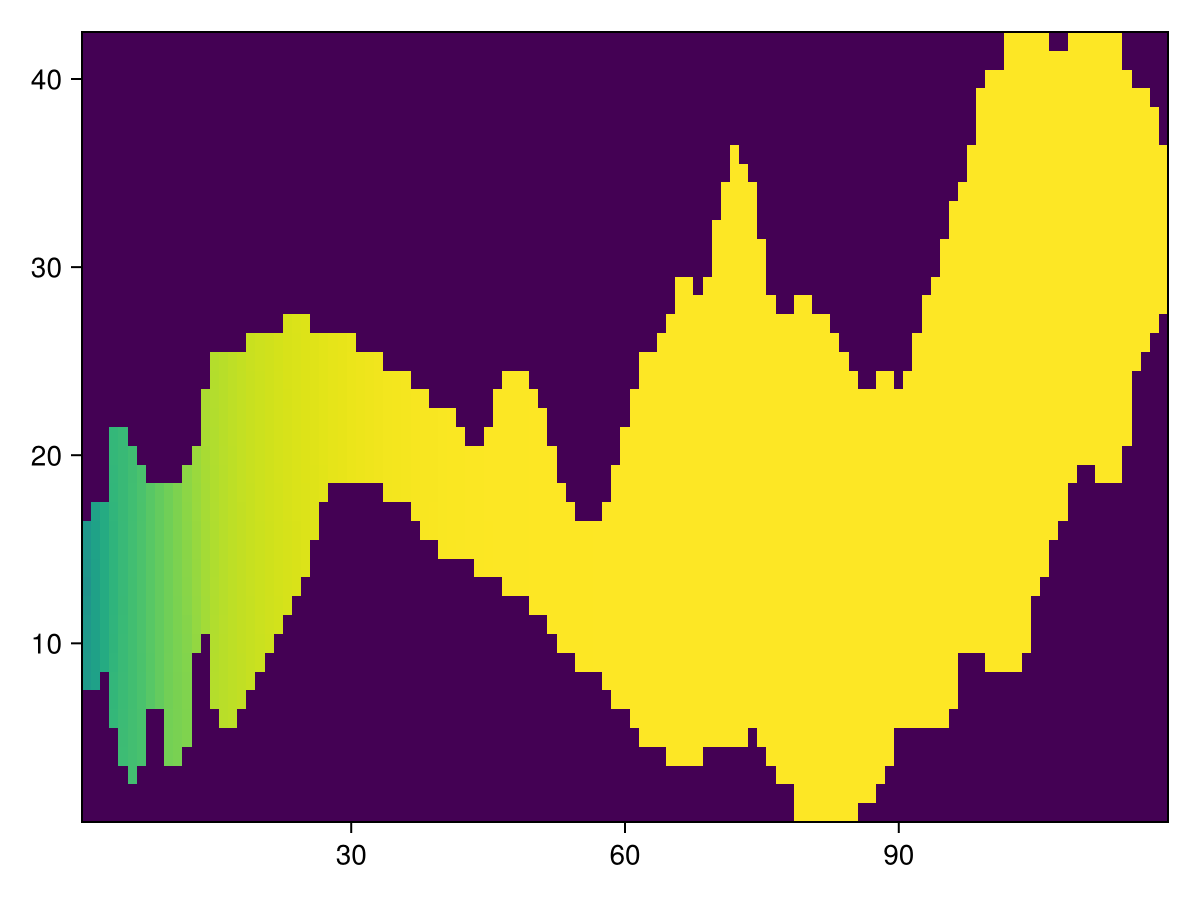

In [57]:
heatmap(interior(model.tracers.S, :, :, grid.Nz))

# Visualization